# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Dewangga Megananda
- **Email:** dewangga.megananda13@gmail.com
- **ID Dicoding:** MC009D5Y0642

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import json
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [2]:
kaggle_api_key = {
    "username": "dewanggamegananda",
    "key": "8c4434a7cb1f0d592d938c73e6bf4ab7"
}

os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_api_key, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)

!kaggle datasets download -d puneet6060/intel-image-classification
with zipfile.ZipFile("intel-image-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("intel_dataset")

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


Train Images Shape: (28068, 64, 64, 3)
Validation Images Shape: (3000, 64, 64, 3)
Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


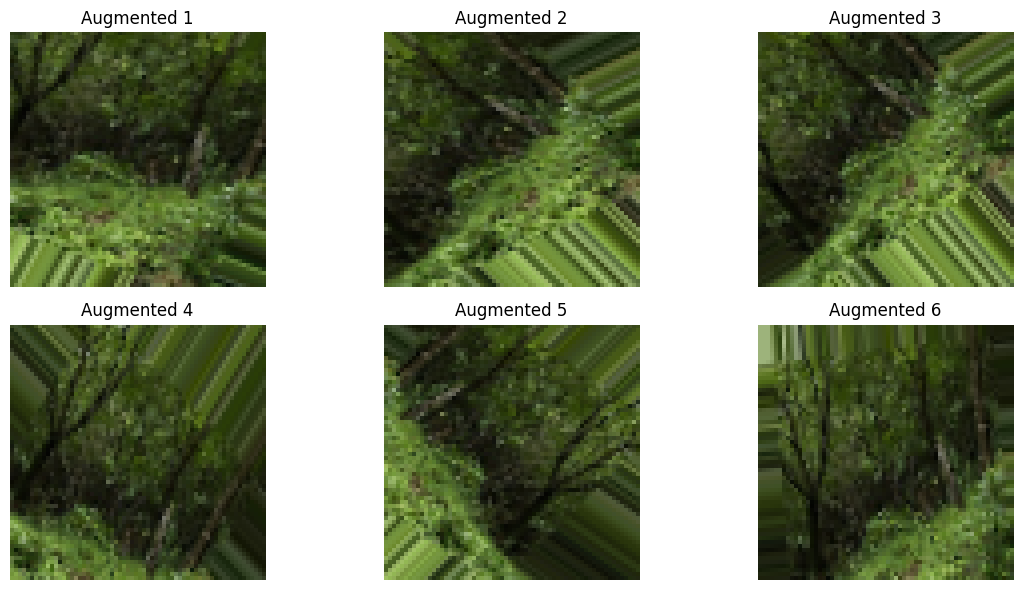

In [3]:
# Konfigurasi global
IMG_SIZE = 64
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
EPOCHS = 30
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_name_label = {name: idx for idx, name in enumerate(class_names)}

# Path dataset
train_path = '/content/intel_dataset/seg_train/seg_train'
val_path = '/content/intel_dataset/seg_test/seg_test'
train_dir = train_path
val_dir = val_path

# ==== Transformasi manual ====
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (64, 64))
    return tf.image.rot90(img, k=random.randint(1, 4))

def clockwise_rotation(img):
    img = tf.image.resize(img, (64, 64))
    return tf.image.rot90(img, k=random.randint(1, 4))

def flip_up_down(img):
    img = tf.image.resize(img, (64, 64))
    return tf.image.flip_up_down(img)

def add_brightness(img):
    img = tf.image.resize(img, (64, 64))
    return tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))

def blur_image(img):
    img = tf.image.resize(img, (64, 64))
    return tf.image.stateless_random_jpeg_quality(img, 30, 100, seed=(1, 2))

def sheared(img):
    img = tf.image.resize(img, (64, 64))
    datagen = ImageDataGenerator(shear_range=0.2)
    return next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]

def warp_shift(img):
    img = tf.image.resize(img, (64, 64))
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    return next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]

transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

train_dir = 'intel_dataset/seg_train/seg_train'
val_dir = 'intel_dataset/seg_test/seg_test'

# ========== 3. AUGMENTATION FUNCTIONS ==========

def apply_random_augmentation(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    ops = [
        lambda x: tf.image.rot90(x, k=random.randint(1, 3)),
        tf.image.flip_up_down,
        lambda x: tf.image.adjust_brightness(x, delta=random.uniform(0.1, 0.5)),
        lambda x: tf.image.stateless_random_jpeg_quality(x, 30, 100, seed=(1, 2))
    ]
    aug_func = random.choice(ops)
    img = aug_func(img)
    return tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

def load_data(path, augment=False):
    images, labels = [], []
    for folder in os.listdir(path):
        if folder not in class_name_label: continue
        label = class_name_label[folder]
        for file in os.listdir(os.path.join(path, folder)):
            try:
                img_path = os.path.join(path, folder, file)
                img = tf.io.read_file(img_path)
                img = tf.image.decode_jpeg(img, channels=3)
                img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img.numpy() / 255.0
                images.append(img)
                labels.append(label)
                if augment:
                    aug_img = apply_random_augmentation(tf.convert_to_tensor(img))
                    images.append(aug_img.numpy() / 255.0)
                    labels.append(label)
            except:
                continue
    return np.array(images), np.array(labels)

# Load data dengan augmentasi
train_images, train_labels = load_data(train_path, augment=True)
val_images, val_labels = load_data(val_path, augment=False)

print("Train Images Shape:", train_images.shape)
print("Validation Images Shape:", val_images.shape)



# ==== Image Augmentation Preview ====
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='sparse'  # pakai sparse karena label integer
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

img_path = f"{train_path}/forest/10007.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (64, 64))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

aug_iter = datagen.flow(img, batch_size=1)
plt.figure(figsize=(12, 6))
for i in range(6):
    batch = next(aug_iter)
    image_aug = batch[0]
    plt.subplot(2, 3, i + 1)
    plt.imshow(image_aug)
    plt.axis('off')
    plt.title(f"Augmented {i+1}")
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [4]:
def load_data(data_path):
    images = []
    labels = []

    for folder in os.listdir(data_path):
        if folder not in class_name_label:
            continue
        label = class_name_label[folder]
        folder_path = os.path.join(data_path, folder)

        for file in tqdm(os.listdir(folder_path), desc=f"Loading {folder}"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error loading image: {img_path}")
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(label)

    images = np.array(images, dtype='float32') / 255.0
    labels = np.array(labels, dtype='int32')
    return images, labels
train_dir = '/content/intel_dataset/seg_train/seg_train'  # Replace with your actual training directory
val_dir = '/content/intel_dataset/seg_test/seg_test'  # Replace with your actual validation directory

train_images, train_labels = load_data(train_dir)
val_images, val_labels = load_data(val_dir)

train_images, train_labels = shuffle(train_images, train_labels, random_state=42)


Loading forest: 100%|██████████| 474/474 [00:00<00:00, 2827.65it/s]


## Modelling

In [5]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(64, (4, 4), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(128, (7, 7), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(len(class_names), activation='softmax')
    ])
    return model

model = build_model()
model.compile(optimizer=Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# ========== 6. TRAINING ==========
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=2)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,510 (5.70 MB)

 Trainable params: 1,493,062 (5.70 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.4266 - loss: 1.5886 - val_accuracy: 0.4967 - val_loss: 1.4497 - learning_rate: 1.0000e-04
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6056 - loss: 1.0522 - val_accuracy: 0.7040 - val_loss: 0.7909 - learning_rate: 1.0000e-04
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6685 - loss: 0.9152 - val_accuracy: 0.7750 - val_loss: 0.6682 - learning_rate: 1.0000e-04
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7038 - loss: 0.8094 - val_accuracy: 0.7010 - val_loss: 0.8822 - learning_rate: 1.0000e-04
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7466 - loss: 0.7127 - val_accuracy: 0.7810 - val_loss: 0.6046 - learning_rate: 1.0000e-04
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7866 - loss: 0.6302 - val_accuracy: 0.8187 - val_loss: 0.5287 - learning_rate: 1.0000e-04
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - a

## Evaluasi dan Visualisasi

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

   buildings       0.85      0.82      0.83       437
      forest       0.95      0.96      0.96       474
     glacier       0.82      0.82      0.82       553
    mountain       0.80      0.82      0.81       525
         sea       0.86      0.86      0.86       510
      street       0.88      0.88      0.88       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



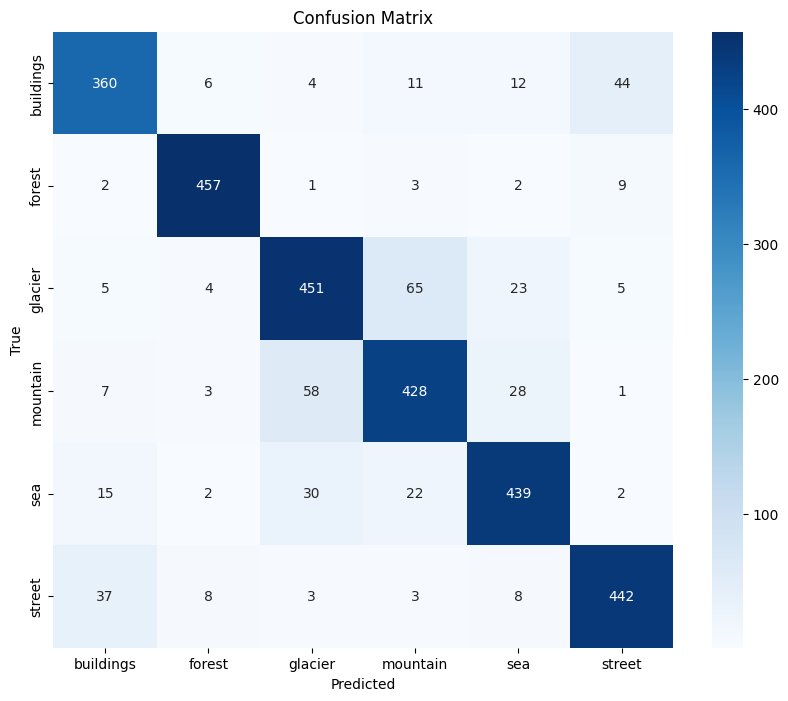

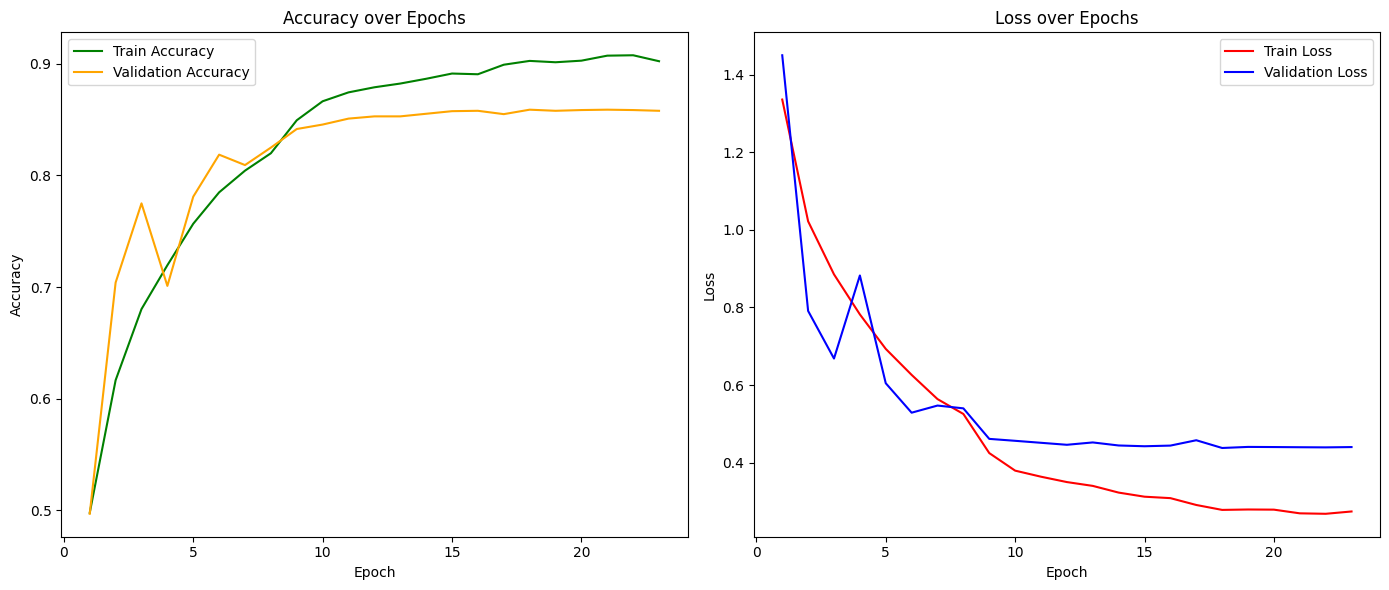

In [6]:
# === Prediksi pada data validasi ===
val_preds = model.predict(val_images)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_labels

# === Classification Report ===
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# === Confusion Matrix ===
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# === Visualisasi Akurasi dan Loss ===
def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc)+1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy', color='green')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', color='red')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi plotting
plot_accuracy_and_loss(history)

## Konversi Model

In [7]:

!pip install tensorflowjs --quiet

import os
import tensorflow as tf


class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


os.makedirs('submission/saved_model', exist_ok=True)
os.makedirs('submission/tflite', exist_ok=True)
os.makedirs('submission/tfjs_model', exist_ok=True)


model.export('submission/saved_model')


converter = tf.lite.TFLiteConverter.from_saved_model('submission/saved_model')
tflite_model = converter.convert()

# Simpan model.tflite
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan label.txt
with open('submission/tflite/label.txt', 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    submission/saved_model \
    submission/tfjs_model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136392594712592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136392594714320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136392594717200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136392594717392: TensorSpec(shape=(), dtype=tf.resource, name

## Inference (Optional)